Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


C:\Users\marie\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
C:\Users\marie\anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


NameError: name 'figure' is not defined

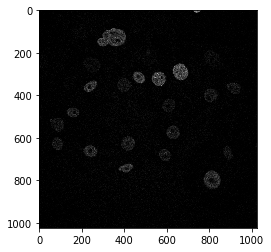

In [8]:
%pylab
%matplotlib inline

from Functions import functions as f
import skimage.io as sk
import matplotlib as mb
import pylab as py

img = sk.imread("Data/N2DH-GOWT1/img/t01.tif") #Bild laden
imshow(img, "gray")

f.show_image(img, 15, 8)